# Introduction to fractal dimension 
In this notebook we will discuss the concept of parametrization of the surface at different scales in a deeper manner. I will repeat the original experiment of Fry Lewis Richardson using Python and the coastline of the great britain.

In [143]:
from __future__ import print_function
try:
    from shapely.geometry import LineString,Point,MultiPoint,LinearRing  
except ImportError:    
    !pip install Shapely
    from shapely.geometry import LineString,Point,MultiPoint,LinearRing
try:
    import geopandas
except ImportError:
    !pip install geopandas
    import geopandas
try:
    import pyproj
except ImportError:
    !pip install pyproj
    import pyproj

In [64]:
from functools import partial
from shapely.ops import transform
import matplotlib.pyplot as plt
import numpy as np
from matplotlib2tikz import save as tikz_save
import os
import sys

In [3]:
plt.rcParams["figure.figsize"] = (18,3)

We create a random profile for initial testing:

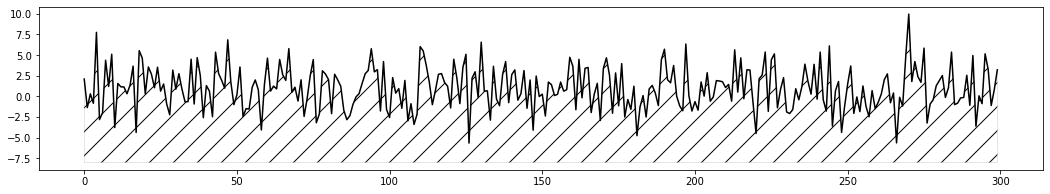

In [4]:
mean, sigma = 1, 2.5 # mean and standard deviation
points = 300
xp = range(points)
yp = np.random.normal(mean, sigma, points)
plt.plot(xp,yp,'k-')
plt.fill_between(xp, -8, yp, facecolor="none", hatch="/", edgecolor="k", linewidth=0.1)
plt.show()

Now we define a `LineString` data structure for rappresenting the profile. This is equivalent to a polyline or a polygonal chain in geometry.

In [5]:
list_of_point = list(zip(xp,yp))
profile = LineString(list_of_point)

We define a function for finding the intersection of the circle with the LineString.

In [6]:
sampling_radius = 10
def find_inter(p,sampling_radius,profile=profile):
    # Create a circle c with a radius = sampling radius.
    c = p.buffer(sampling_radius).boundary
    # Find intersection of the circle with the profile.
    i = c.intersection(profile)
    #print i
    return i


In [7]:
p1 = find_inter(Point(list(list_of_point)[0]),sampling_radius=sampling_radius)
print(p1)

POINT (9.635551967371255 -0.540739664921876)


In [8]:
%qtconsole

Now we iterate the function for the for the first 40 values. The point found will be used as a next starting point for the new iteration.

In [9]:
# we define the starting point
point = Point(list_of_point[0])
intersections  = []
points_found = []
points_found.append(point)
for i in range(40):
    pointx = point.coords[0][0]
    # we find the next point (the intersection)
    point = find_inter(point,sampling_radius,profile=profile)
    intersections.append(point)
    # if there is more than one interesection we will have a multi point
    if type(point) is MultiPoint:
        listx = np.array([i.coords[0][0] for i in point])
        # find the smallest value after the starting point
        value = listx[listx > pointx].min()
        # This is true for profile following a straight line because they
        # ordered  
        itemindex = np.where(listx==value)
        point = point[itemindex[0][0]]
        points_found.append(point)
    else:
        points_found.append(point)

In [10]:
multi = intersections[3]
multi[0].coords[0]

(17.126263043188082, -3.126476993180834)

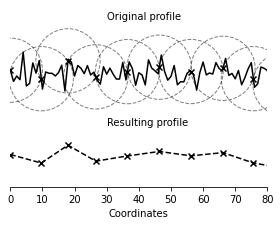

In [11]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
maxyp, minyp = max(yp),min(yp)
ax.plot(xp,yp,'k-')
for inter in intersections:
    # if there is more than one intersection
    if type(inter) is MultiPoint:
        for j in inter:
            x,y = j.coords[0]
            # we can plot all the intersections found
            #ax.scatter(x,y,color='k',marker='x',alpha=0.5)
    else:
        x,y = inter.coords[0]
        #ax.scatter(x,y,color='b',marker='x')
for pt in points_found:
    x,y = pt.coords[0]
    circle1 = plt.Circle((x, y), sampling_radius, color='k', fill=False,linestyle='--',alpha=0.5)
    ax.add_artist(circle1)

xn,yn = np.array([pt.coords[0] for pt in points_found]).T
ax.scatter(xn,yn,color='k',marker='x')
maxyn, minyn = max(yn),min(yn)
#ax.plot(xn,yn,linestyle='--',color='g')
ax.set_aspect('equal')
shifteyn = yn - maxyn - abs(minyp) - sampling_radius*1.2
ax.plot(xn,shifteyn,linestyle='--',color='k')
ax.scatter(xn,shifteyn,color='k',marker='x')
ax.set_ylim(min(shifteyn)+min(shifteyn)*0.2,maxyp+sampling_radius*1.2)
ax.set_xlim(0,80)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_xlabel("Coordinates")
ax.text(30,18,'Original profile')
ax.text(30,-15,'Resulting profile')
plt.tight_layout()
plt.show()

We have try now to deal with more complex shapes. In particular when we have more than one point for coordinate.
We will create a new algorithm for dealing with countries geometries, using setellite images converted to shapefiles as sample data.

This data has been extracted from https://www.ngdc.noaa.gov/mgg/shorelines/data/gshhg/latest/gshhg-shp-2.3.7.zip (last modified 2018-03-02 18:42). GSHHG is released under the GNU Lesser General Public license, and is developed and maintained by Dr. Paul Wessel, SOEST, University of Hawai, and Dr. Walter H. F. Smith, NOAA Laboratory for Satellite Altimetry. To reproduce the experiment by Richardson I extracted the coast of Great Britain and saved in a .shp file.

In [12]:
gbr = geopandas.read_file(os.path.join('Data','ID_15_GSHHS_F_L1.shp'))
len(list(gbr.geometry.iloc[0].coords))

49153

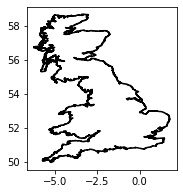

In [13]:
gbr.plot(color='k')

We check the Coordinate Reference System :

In [124]:
gbr.crs

0    127.676954
dtype: float64

EPSG:4326 return coordinates in degrees so we hava to convert them in meters or kilometers.

In [15]:
gbr_points = np.array(list(gbr.geometry.iloc[0].coords))

The problem when deling with the boareders of the countries is that we might have some intersection closer to the origin point which are actually very far along the coast. So we have to select the first intersection following the coastline. To understand better this problem we create a small syntetic coastline.

In [16]:
xpt = [-6,1,2,2.5,4,1,-1,2,4,5,6,]
ypt = [-8,1,1,0,1,2,2,3,4,4,4,]
sampling_radius=1.5
list_of_point = list(zip(xpt,ypt))
p = Point(2,1)
profile = LineString(list_of_point)

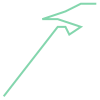

In [17]:
profile

We now find the intersections using the function that we previously developed.

In [18]:
points = find_inter(Point(2,1),sampling_radius=1.5,profile=profile)

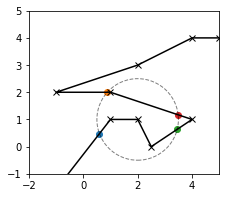

In [19]:
# defining the plot adn plotting the original data
fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
ax3.set_xlim(-2,5)
ax3.set_ylim(-1,5)
maxyp, minyp = max(ypt),min(ypt)
ax3.plot(xpt,ypt,'k',marker = 'x')
ax3.set_aspect('equal')
# plot the results
circle_radius = 1.5
circle1 = plt.Circle((2,1), sampling_radius, color='k', fill=False,linestyle='--',alpha=0.5)
# we plot the intersection 
for i in np.array(points):
    ax3.scatter(i[0],i[1])
#ax3.annotate(-1,0,1,1)
ax3.add_artist(circle1)

We can see that the cricle with origin at the point (2,1)  has four intersection only the first intersection relative to the direction of motion must be considered. The algorithm proposed, iterate over the segments, if the segment do not intersect the circle the next segment is chosen. If the next segment intersect the circle in only one point the intersection will be the next point from where a new circle will be drawn. If it intersects the segement in two points (which is the maximum number of intersection per segment). The intersection  closest to the origin point is choosen.

Eventually, we must consider the case that the segment is very long so we might have multiple intersection on the same segments. All the cases are treat in the following algorithm that I called Richardson filter.

In [37]:
def Richardson_filter(splitted_profile,sampling_radius):
    currentpoint = splitted_profile[0].coords[0]
    intersections_list = [currentpoint]
    #every_intersection = []
    p = Point(currentpoint)
    c = p.buffer(sampling_radius).boundary
    index = 0
    #if splitted_profile[0].intersection(c)
    inline = False # True when the previous point was on the same segment
    progress = 0
    while index < len(splitted_profile):
        # This is the progress bar
        j = (index + 1) / len(splitted_profile)
        sys.stdout.write('\r')
        sys.stdout.write("[%-20s] %d%%" % ('='*int(20*j), 100*j))
        sys.stdout.flush()
        # we find the intersection with the current point
        intersections = splitted_profile[index].intersection(c)
        #every_intersection.append(intersections)
        # First case we have a single intersection
        if (type(intersections) is Point):
            if inline:
                # if the intersection is in the same line of the
                # previuous one we must check that we are not
                # going backward
                # we get the origin of the segment
                xs,ys  = splitted_profile[index].coords[0]
                xi,yi = intersections.coords[0]
                # and the point of the previous intersection
                xp, yp = intersections_list[-1]
                # we calculate the distance from the origin
                # for the new intersection
                dist_inter = ((xs-xi)**2 + (ys-yi)**2 )**0.5
                # and the previous one
                dist_old = ((xs-xp)**2 + (ys-yp)**2)**0.5
                if dist_inter > dist_old:
                    # if we are getting far from the origin
                    # we store it
                    currentpoint = intersections
                    c = currentpoint.buffer(sampling_radius).boundary
                    intersections_list.append(intersections.coords[0])
                    inline = True
                    continue
                else:
                    # otherwise it means that we are going back
                    # so for going furhter we must go to the next segment
                    index +=1
                    inline = False
                    continue
            else:
                # if it's a new segment we have no problem of direction
                currentpoint = intersections
                c = currentpoint.buffer(sampling_radius).boundary
                intersections_list.append(intersections.coords[0])
                inline = True
                continue

        # Second case we find more than one intersection
        if type(intersections) is MultiPoint:
            # A segment can intersect a circle in at maximum two points
            # coordinates of the origin of the segment
            xs,ys  = splitted_profile[index].coords[0]
            # coordinates first point
            xa, ya = intersections[0].x,intersections[0].y
            # coordinates second point
            xb, yb = intersections[1].x,intersections[1].y
            # distance frist point from the origin
            dist_a = ((xs-xa)**2 + (ys-ya)**2 )**0.5
            # distance second point from the origin
            dist_b = ((xs-xb)**2 + (ys-yb)**2)**0.5
            # we check which is the further from the origin
            if dist_a > dist_b:
                currentpoint = intersections[0]
            else:
                currentpoint = intersections[1]
            c = currentpoint.buffer(sampling_radius).boundary
            intersections_list.append(currentpoint.coords[0])
            inline = True
            continue

        # Third case we don't find any intersection    
        else:
            # we pass to the next segment if the current circle
            # do not intersect with it.
            # Rememeber more than one circles could intersect with
            # a segment excpecially if it's very long
            index +=1
            inline = False
    return intersections_list

Before using the algoritm we must extract form the shapefile the points.

In [26]:
from shapely.ops import split
def split_profile(profile):
    points_to_split = MultiPoint([Point(x,y) for x,y in profile.coords[1:]])
    print("Splitting...")
    splitted_profile = split(profile,points_to_split)
    print("splitted_profile points...")
    return splitted_profile

This function is slower but it shows the progress.

In [39]:
def split_profile_slow(profile):
    splitted = []
     # Progress bar
    for index in range(len(profile.coords) -1):
        splitted.append(LineString([profile.coords[index], profile.coords[index+1]]))
        j = (index + 1) / len(profile.coords)
        sys.stdout.write('\r')
        # the exact output you're looking for:
        sys.stdout.write("[%-20s] %d%%" % ('='*int(20*j), 100*j))
        sys.stdout.flush()
    return splitted

In [40]:
splitted_profile = split_profile_slow(profile)

[==================  ] 90%

[====================] 100%

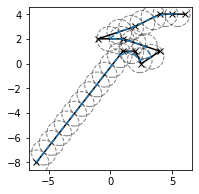

In [41]:
sampling_radius = 1
intersections_list = Richardson_filter(splitted_profile,sampling_radius=sampling_radius)
fig4 = plt.figure()
ax4 = fig4.add_subplot(111)
#ax4.set_xlim(-3,5)
#ax4.set_ylim(-2,5)
ax4.plot(xpt,ypt,'k',marker = 'x')
ax4.set_aspect('equal')
for x,y in intersections_list:
    circle1 = plt.Circle((x,y), sampling_radius, color='k', fill=False,linestyle='--',alpha=0.5)
    ax4.add_artist(circle1)
ax4.plot(np.array(intersections_list)[:,0],np.array(intersections_list)[:,1],'--')


# Applying the algorithm to the coastiline of Great Britain
We finally applyt the algorithm to the coastline fo Great Britain after converting the shape file on segments.

In [38]:
splitted_gbr = split_profile_slow(gbr.geometry.iloc[0])

[                    ] 0%%%

In [76]:
sampling_radius = 2 # degree
intersections_list = Richardson_filter(splitted_gbr,sampling_radius=sampling_radius)

[====================] 100%

We define a function for plotting the results.

In [81]:
def plot_intersection(intersections_list,sampling_radius=None):
    fig4 = plt.figure()
    ax4 = fig4.add_subplot(111)
    #ax4.plot(xpt,ypt,'k',marker = 'x')
    ax4.set_aspect('equal')
    if sampling_radius is not None:
        for x,y in intersections_list:
            circle1 = plt.Circle((x,y), sampling_radius, color='k', fill=False,alpha=0.2)
            ax4.add_artist(circle1)
    ax4.plot(np.array(intersections_list)[:,0],np.array(intersections_list)[:,1],'--')
    gbr.plot(color='gray',ax = ax4,alpha=0.5)
    ax4.set_xlim(-8,4)
    ax4.set_ylim(48,61)

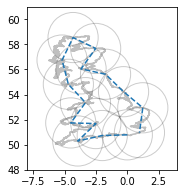

In [82]:
plot_intersection(intersections_list,sampling_radius = 2)

In [46]:
sampling_radius = 1 # degree
intersections_list_r1 = Richardson_filter(splitted_gbr,sampling_radius=sampling_radius)

[=================== ] 98%

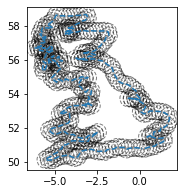

In [65]:
plot_intersection(intersections_list_r2)

In [66]:
sampling_radius = 0.5 # degree
intersections_list_r05 = Richardson_filter(splitted_gbr,sampling_radius=sampling_radius)

[====================] 100%

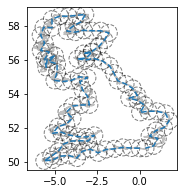

In [61]:
plot_intersection(intersections_list_r05)

In [83]:
sampling_radius = 0.01 # degree
intersections_list_r001 = Richardson_filter(splitted_gbr,sampling_radius=sampling_radius)

[====================] 100%

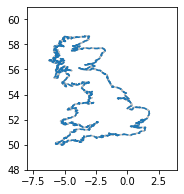

In [84]:
plot_intersection(intersections_list_r001)

In [125]:
sampling_radius = 0.001 # degree
intersections_list_r0001 = Richardson_filter(splitted_gbr,sampling_radius=sampling_radius)

[====================] 100%

In [128]:
sampling_radius = 0.0001 # degree
intersections_list_r00001 = Richardson_filter(splitted_gbr,sampling_radius=sampling_radius)

[====================] 100%=================== ] 97%

## Calculating the length 
The last step is to calculate the lenght. For this we convert the linestring obtained to the EPSG:27700 Cordinate Reference System and then we compute the lenght of the polyline divided by 1000 to get the lenght in km.
This procedure is more accurate compared to the procedure used by Richardson that multiplied the numebero of steps taken to measure the coastline with the correspective distance in Km measured between the spikes of the compass. 

In [122]:
def calculate_length(intersections):
    # for closing the shape we append the first point to the end of the polyline
    intersections.append(intersections[-1])
    polyline = LineString(intersections)  # we create the polyline
    wgs84 = pyproj.Proj(init='epsg:4326') # we define the original CRS
    utm = pyproj.Proj(init='epsg:27700')  # and the target CRS
    
    # we generate the trasformation
    project = partial(
        pyproj.transform,
        wgs84,
        utm)

    utm_polyline = transform(project, polyline)
    length_km = utm_polyline.length/1000
    avarage_step = length_km/len(intersections)
    return length_km,avarage_step

In [129]:
calculate_length(intersections_list_r00001)

(10122.369560362804, 0.007947958991507256)

In [131]:
sampling_radii = [0.001,0.005,0.01,0.05,0.1,0.5,0.8,1.2,1.5,1.8,2]

In [132]:
intersections_all = []
lengths_and_radius_inKm = []
tot = len(sampling_radii)
for ind, i in enumerate(sampling_radii):
    intr = Richardson_filter(splitted_gbr,sampling_radius=i)
    intersections_all.append(intr)
    lengths_and_radius_inKm.append(calculate_length(intr))
    print("%s/%s" %(ind+1,tot))

[=================== ] 99%%[=====               ] 26%

Text(0, 0.5, 'Total length (km)')

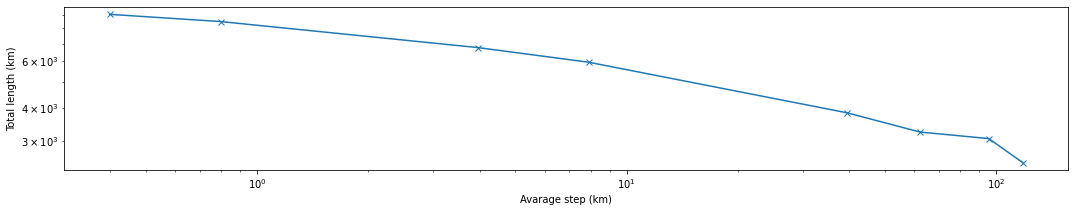

In [180]:
data = np.array(lengths_and_radius_inKm)
lengths = data[1:-2,0]
steps = data[1:-2,1]
plt.loglog(steps,lengths,marker='x')
plt.xlabel("Avarage step (km)")
plt.ylabel("Total length (km)")

In [181]:
y = np.log(lengths[2:-1])/np.log(1/steps[2:-1])

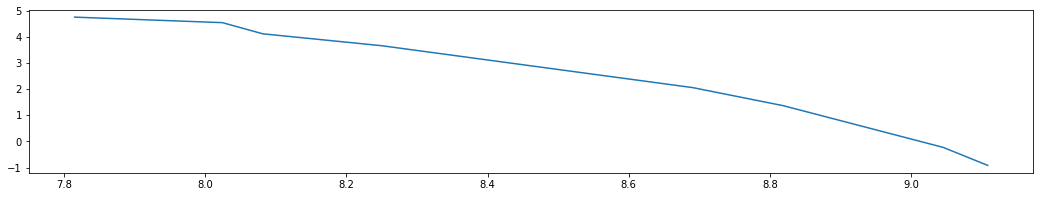

In [183]:
plt.plot(np.log(lengths),np.log(steps))

In [ ]:
from scipy.optimize import curve_fit

def f(x, A, B): 
    return A*x + B

popt, pcov = curve_fit(f, x, y)
slope = popt[0] # fractal dimension

# Using directly EPSG:27700
Here we present also another approch, to convert directly the map to a CRS with meter as units and use directly this CRS for performing the analysis.

In [145]:
gbr.crs

{'init': 'epsg:4326'}

In [146]:
# Could not work 
# gbr_epsg27700 = gbr.to_crs("epsg:27700")

In [149]:
wgs84 = pyproj.Proj(init='epsg:4326') # we define the original CRS
utm = pyproj.Proj(init='epsg:27700')  # and the target CRS

# we generate the trasformation
project = partial(
    pyproj.transform,
    wgs84,
    utm)

gbr_epsg27700 = transform(project, gbr.geometry.iloc[0])

In [157]:
splitted_gbr_epsg27700 = split_profile_slow(gbr_epsg27700)

[=================== ] 99%

In [168]:
intersections_allepsg27700 = []
lengths_inKmepsg27700 = []
tot = len(sampling_radii)
sampling_radii_K = [1,10,50,100,150,200,250,500,750,1000]
for ind, i in enumerate(sampling_radii_K):
    intr = Richardson_filter(splitted_gbr_epsg27700,sampling_radius=i*1000)
    intersections_allepsg27700.append(intr)
    lengths_inKmepsg27700.append(LineString(intr).length/1000)
    print("%s/%s done!" %(ind+1,tot))

[====================] 100%1/11 done!
[====================] 100%2/11 done!
[====================] 100%3/11 done!
[====================] 100%4/11 done!
[====================] 100%5/11 done!
[====================] 100%6/11 done!
[====================] 100%7/11 done!
[====================] 100%8/11 done!
[=================== ] 99%

0


Text(0, 0.5, 'Total length (km)')

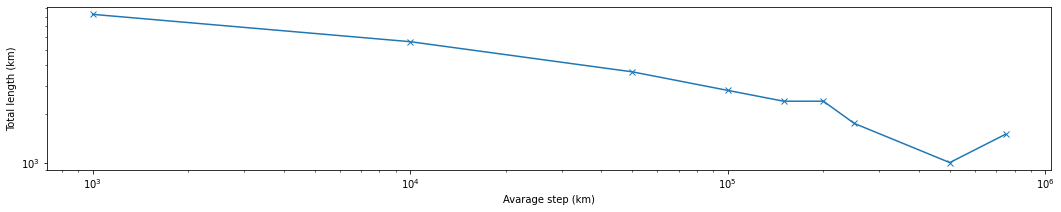

In [171]:
print(len(intersections_allepsg27700))
steps_km = np.array(sampling_radii_K)*1000
plt.loglog(steps_km[:-1],lengths_inKmepsg27700,marker='x')
plt.xlabel("Avarage step (km)")
plt.ylabel("Total length (km)")

# Rolling circle envelope 
The method used by Richardson, maybe substit

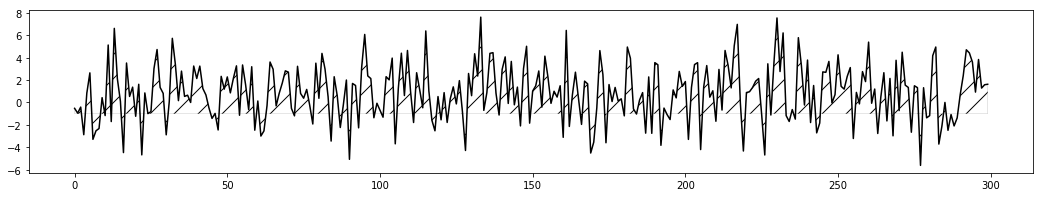

In [15]:
mean, sigma = 1, 2.5 # mean and standard deviation
points = 300
xp = range(points)
yp = np.random.normal(mean, sigma, points)
plt.plot(xp,yp,'k-')
plt.fill_between(xp, -1, yp, facecolor="none", hatch="/", edgecolor="k", linewidth=0.1)
plt.show()

In [16]:
list_of_point = list(zip(xp,yp))
profile = LineString(list_of_point)

In [17]:
circle_radius = 2
max_value = max(yp)
# The circle will never encounter value above the max value of the profile
starting_ycoord = max_value + circle_radius
min_ycord = min(yp) + circle_radius
# TODO: we could optimize the range over windows of the size of the diameters.
points = []
traiectory = []
for step in range(40):
    xcoor = list_of_point[step][0]
    max_value = list_of_point[step][1] + circle_radius*0.9
    for y in np.linspace(starting_ycoord,max_value):
        p = Point(xcoor,y)
        # Create a circle c with a radius = sampling radius.
        c = p.buffer(circle_radius).boundary
        # Find intersection of the circle with the profile.
        traiectory.append((xcoor,y))
        if c.intersects(profile):
            points.append((xcoor,y))
            break

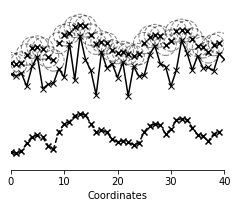

In [18]:

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
maxyp, minyp = max(yp),min(yp)
ax2.plot(xp,yp,'k',marker = 'x')

for pt in points:
    circle1 = plt.Circle(pt, circle_radius, color='k', fill=False,linestyle='--',alpha=0.5)
    ax2.add_artist(circle1)
#traiectory
#xt,yt = np.array(traiectory).T
#ax2.scatter(xt,yt,color='g',marker = 'x',alpha=0.4)
    
xn,yn = np.array(points).T
ax2.scatter(xn,yn,color='k',marker='x')
maxyn, minyn = max(yn),min(yn)
#ax.plot(xn,yn,linestyle='--',color='g')
ax2.set_aspect('equal')
shifteyn = yn - maxyn - abs(minyp) - circle_radius*1.2
ax2.plot(xn,shifteyn,linestyle='--',color='k')
ax2.scatter(xn,shifteyn,color='k',marker='x')
ax2.set_ylim(min(shifteyn)+min(shifteyn)*0.2,maxyp+circle_radius*2.2)
ax2.set_xlim(0,40)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
ax2.set_xlabel("Coordinates")
#fig.savefig("fig3.pgf")
#tikz_save("test3.tex")
# unit vector ratio*=1 1 1,
plt.show()


# Under

In [31]:
def Richardson_filter2(splitted_profile,sampling_radius):
    currentpoint = splitted_profile[0].coords[0]
    intersections_list = [currentpoint]
    every_intersection = []
    p = Point(currentpoint)
    c = p.buffer(sampling_radius).boundary
    index = 0
    #if splitted_profile[0].intersection(c)
    inline = False # True when the previous point was on the same segment
    progress = 0
    while index < len(splitted_profile):
        # we find the intersection with the current circle
        intersections = splitted_profile[index].intersection(c)
        print("!"+str(splitted_profile[index]))
        every_intersection.append(intersections)
        # First case we have found a single intersection of the segment splitted_profile[index]
        if (type(intersections) is Point):
            if inline:
                # if the intersection is in the same line of the
                # previuous one we must check that we are not
                # going backward
                # being a line there if we are going backward it means we
                # are finding the previous intersection
                # hence if it is different 
                if intersections.coords[0] != intersections_list[-1]:
                    currentpoint = intersections
                    c = currentpoint.buffer(sampling_radius).boundary
                    intersections_list.append(intersections.coords[0])
                    inline = True
                    continue
                else:
                    # otherwise it means that we are going back
                    # so for going furhter we must go to the next segment
                    # we add one to the index and we continue the while loop
                    print('equal')
                    print('->',intersections.coords[0],'--',intersections_list[-1])
                    index +=1
                    inline = False
                    continue
            else:
                # if it's a new segment we have no problem of direction
                currentpoint = intersections
                c = currentpoint.buffer(sampling_radius).boundary
                intersections_list.append(intersections.coords[0])
                inline = True
                continue

        # Second case we find more than one intersection
        if type(intersections) is MultiPoint:
            # A segment can intersect a circle in at maximum two points
            # coordinates of the origin of the segment
            xs,ys  = splitted_profile[index].coords[0]
            # coordinates first point
            xa, ya = intersections[0].x,intersections[0].y
            # coordinates second point
            xb, yb = intersections[1].x,intersections[1].y
            # distance frist point from the origin
            dist_a = ((xs-xa)**2 + (ys-ya)**2 )**0.5
            # distance second point from the origin
            dist_b = ((xs-xb)**2 + (ys-yb)**2)**0.5
            # we check which is the further from the origin
            if dist_a > dist_b:
                currentpoint = intersections[0]
            else:
                currentpoint = intersections[1]
            c = currentpoint.buffer(sampling_radius).boundary
            intersections_list.append(currentpoint.coords[0])
            inline = True
            continue

        # Third case we don't find any intersection    
        else:
            # we pass to the next segment if the current circle
            # do not intersect with it.
            # Rememeber more than one circles could intersect with
            # a segment excpecially if it's very long
            index +=1
            inline = False
    return intersections_list,every_intersection